# Shahir Rahman

In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from torchsummary import summary

from lab2_lib.datasets import *
from lab2_lib.training import *
from lab2_lib.evaluation import *
from lab2_lib.models.mobilenet_v2 import *
from lab2_lib.models.mobilenet_v3 import *

In [2]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version: 1.8.0
Torchvision Version: 0.9.0
Using the GPU!


In [3]:
# Training was done ad-hoc style by sometimes stopping a cell, modifying data augmentation
# (after I did some more research) or manually setting learning rates and restarting training
# Thus even though these seeds set the starting point, there are 100s (400+) of epochs within
# the training so this doesn't particularly matter

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
data_dir = "dataset/"
weights_dir = "weights/"
session_dir = "sessions/"

In [5]:
# orig_datasets = get_datasets(data_dir,
#                              val_frac=0.2,
#                              train_use_val=False)
orig_datasets = get_datasets(data_dir,
                             val_frac=1.0,
                             train_use_val=True)

Original Data
Training


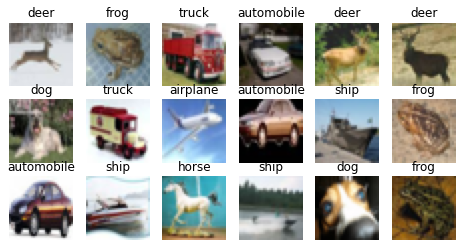

Validation


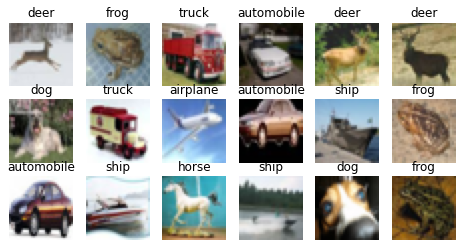

Testing


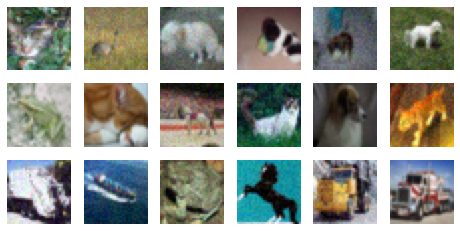

In [6]:
print("Original Data")

print("Training")
view_dataset_samples(orig_datasets['train'], labeled=True)

print("Validation")
view_dataset_samples(orig_datasets['val'], labeled=True)

print("Testing")
view_dataset_samples(orig_datasets['test'], labeled=False)

In [7]:
augmented_datasets = apply_transforms_multi_crop(orig_datasets,
                                                 random_erasing=False,
                                                 use_cutmix=True,
                                                 apply_train_defense=True,
                                                 num_crops_test=1)

In [8]:
dataloaders = get_dataloaders(augmented_datasets,
                              train_batch_size=128,
                              test_val_batch_size=64,
                              num_workers=4)

In [9]:
# model = MobileNetV2()
# model = model.to(device)

In [10]:
model = get_mobilenetv3_cifar(1.0)
model = model.to(device)

In [11]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           H_swish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             144
       BatchNorm2d-5           [-1, 16, 32, 32]              32
 AdaptiveAvgPool2d-6             [-1, 16, 1, 1]               0
            Linear-7                    [-1, 4]              64
              ReLU-8                    [-1, 4]               0
            Linear-9                   [-1, 16]              64
        H_sigmoid-10                   [-1, 16]               0
         SEModule-11           [-1, 16, 32, 32]               0
             ReLU-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]             256
      BatchNorm2d-14           [-1, 16,

In [12]:
num_epochs = 400

criterion = get_loss(use_cutmix=True)
criterion = criterion.to(device)

# train phase 1 (initial trianing with cutmix & other data augmentation)
optimizer = make_optimizer(model, lr=0.005, verbose=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [30, 80, 140, 200], gamma=0.2)

# train phase 2 (with extra stuff like gaussian blur, etc.)
optimizer = make_optimizer(model, lr=0.002, verbose=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [40, 80, 140, 200], gamma=0.2)

# train phase 3 (just train for a very long time to squeeze out the performance) (around ~5% acc gained here over around 300-400 epochs)
optimizer = make_optimizer(model, lr=0.001, weight_decay=2e-6, verbose=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [20, 50, 110, 270], gamma=0.2)

### MobileNetV2 Weights

In [13]:
# past_session_dir = os.path.abspath(os.path.join(session_dir, "Session 03-14-2021 11-41PM"))
# _ = load_training_session(model, optimizer, past_session_dir)

In [14]:
# past_train_weights = os.path.abspath(os.path.join(weights_dir, "Experiment 03-15-2021 03-05AM MobileNetV2 Best/Weights Best.pckl"))
# model.load_state_dict(torch.load(past_train_weights))

### MobilenetV3 Weights

In [15]:
# past_session_dir = os.path.abspath(os.path.join(session_dir, "Session 03-15-2021 10-37AM"))
# _ = load_training_session(model, optimizer, past_session_dir)
# loading training sessions loads optimizer state as well

In [17]:
# past_train_weights = os.path.abspath(os.path.join(weights_dir, "Experiment 03-15-2021 03-54PM/Weights Best.pckl"))
past_train_weights = os.path.abspath(os.path.join(weights_dir, "Experiment 03-15-2021 05-56PM MobileNetV3_small_32_1.0_type1 Best 2/Weights Best Saved 1.pckl"))
past_train_weights = os.path.abspath(os.path.join(weights_dir, "Experiment 03-15-2021 09-34PM/Weights Best.pckl"))
model.load_state_dict(torch.load(past_train_weights))

<All keys matched successfully>

In [18]:
from advertorch.attacks import *
adversary = LinfPGDAttack(
    model, loss_fn=criterion, eps=0.3,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)
adversary = L1PGDAttack(model, loss_fn=criterion, nb_iter=10)
adversary = GradientSignAttack(model, loss_fn=criterion)

In [ ]:
tracker = train_model(device=device,
                      model=model,
                      dataloaders=dataloaders,
                      criterion=criterion,
                      optimizer=optimizer,
                      lr_scheduler=scheduler,
                      save_log=True,
                      save_model=True,
                      save_dir=weights_dir,
                      save_best=True,
                      save_all=True,
                      num_epochs=num_epochs,
                      multi_crop_val=False,
                      use_cutmix=True,
                      adversary=None)

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Epoch 0/399
----------
Training


Avg. Loss: 1.2098, Total Loss: 1.4198, Loss Parts: [1.4198]: 100%|███████████████████| 391/391 [00:30<00:00, 12.91it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2098
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0767
Validation accuracy 0.8940

Epoch 1/399
----------
Training


Avg. Loss: 1.2118, Total Loss: 1.0937, Loss Parts: [1.0937]: 100%|███████████████████| 391/391 [00:35<00:00, 11.13it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2118
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0810
Validation accuracy 0.8876

Epoch 2/399
----------
Training


Avg. Loss: 1.2199, Total Loss: 1.3313, Loss Parts: [1.3313]: 100%|███████████████████| 391/391 [00:31<00:00, 12.59it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2199
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0772
Validation accuracy 0.8941

Epoch 3/399
----------
Training


Avg. Loss: 1.2147, Total Loss: 1.1895, Loss Parts: [1.1895]: 100%|███████████████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2147
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0779
Validation accuracy 0.8946

Epoch 4/399
----------
Training


Avg. Loss: 1.2148, Total Loss: 1.1917, Loss Parts: [1.1917]: 100%|███████████████████| 391/391 [00:31<00:00, 12.37it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2148
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0779
Validation accuracy 0.8933

Epoch 5/399
----------
Training


Avg. Loss: 1.2200, Total Loss: 1.1906, Loss Parts: [1.1906]: 100%|███████████████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2200
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0787
Validation accuracy 0.8936

Epoch 6/399
----------
Training


Avg. Loss: 1.2178, Total Loss: 1.3660, Loss Parts: [1.3660]: 100%|███████████████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2178
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0780
Validation accuracy 0.8947

Epoch 7/399
----------
Training


Avg. Loss: 1.2138, Total Loss: 1.2849, Loss Parts: [1.2849]: 100%|███████████████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2138
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0777
Validation accuracy 0.8922

Epoch 8/399
----------
Training


Avg. Loss: 1.2129, Total Loss: 1.3198, Loss Parts: [1.3198]: 100%|███████████████████| 391/391 [00:31<00:00, 12.38it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2129
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0770
Validation accuracy 0.8928

Epoch 9/399
----------
Training


Avg. Loss: 1.2161, Total Loss: 1.3733, Loss Parts: [1.3733]: 100%|███████████████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2161
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0802
Validation accuracy 0.8930

Epoch 10/399
----------
Training


Avg. Loss: 1.2129, Total Loss: 1.2668, Loss Parts: [1.2668]: 100%|███████████████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2129
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0759
Validation accuracy 0.8959

Epoch 11/399
----------
Training


Avg. Loss: 1.2083, Total Loss: 1.2272, Loss Parts: [1.2272]: 100%|███████████████████| 391/391 [00:29<00:00, 13.06it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2083
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0840
Validation accuracy 0.8928

Epoch 12/399
----------
Training


Avg. Loss: 1.2060, Total Loss: 1.2924, Loss Parts: [1.2924]: 100%|███████████████████| 391/391 [00:30<00:00, 12.90it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2060
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0773
Validation accuracy 0.8950

Epoch 13/399
----------
Training


Avg. Loss: 1.2113, Total Loss: 1.1767, Loss Parts: [1.1767]: 100%|███████████████████| 391/391 [00:30<00:00, 13.03it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2113
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0780
Validation accuracy 0.8932

Epoch 14/399
----------
Training


Avg. Loss: 1.2158, Total Loss: 1.4275, Loss Parts: [1.4275]: 100%|███████████████████| 391/391 [00:34<00:00, 11.33it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2158
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0759
Validation accuracy 0.8950

Epoch 15/399
----------
Training


Avg. Loss: 1.2082, Total Loss: 1.1168, Loss Parts: [1.1168]: 100%|███████████████████| 391/391 [00:30<00:00, 12.75it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2082
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0764
Validation accuracy 0.8946

Epoch 16/399
----------
Training


Avg. Loss: 1.2061, Total Loss: 1.2200, Loss Parts: [1.2200]: 100%|███████████████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2061
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0756
Validation accuracy 0.8967

Epoch 17/399
----------
Training


Avg. Loss: 1.2100, Total Loss: 1.1299, Loss Parts: [1.1299]: 100%|███████████████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2100
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0755
Validation accuracy 0.8976

Epoch 18/399
----------
Training


Avg. Loss: 1.2085, Total Loss: 1.2150, Loss Parts: [1.2150]: 100%|███████████████████| 391/391 [00:31<00:00, 12.60it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.2085
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0787
Validation accuracy 0.8946

Epoch 19/399
----------
Training


Avg. Loss: 1.1988, Total Loss: 1.3571, Loss Parts: [1.3571]: 100%|███████████████████| 391/391 [00:33<00:00, 11.67it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1988
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0736
Validation accuracy 0.8997

Epoch 20/399
----------
Training


Avg. Loss: 1.1977, Total Loss: 1.2980, Loss Parts: [1.2980]: 100%|███████████████████| 391/391 [00:27<00:00, 14.01it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1977
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0708
Validation accuracy 0.9041

Epoch 21/399
----------
Training


Avg. Loss: 1.1903, Total Loss: 1.1559, Loss Parts: [1.1559]: 100%|███████████████████| 391/391 [00:33<00:00, 11.56it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1903
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0701
Validation accuracy 0.9051

Epoch 22/399
----------
Training


Avg. Loss: 1.1863, Total Loss: 1.2763, Loss Parts: [1.2763]: 100%|███████████████████| 391/391 [00:31<00:00, 12.53it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1863
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0723
Validation accuracy 0.9032

Epoch 23/399
----------
Training


Avg. Loss: 1.1840, Total Loss: 1.1483, Loss Parts: [1.1483]: 100%|███████████████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1840
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0689
Validation accuracy 0.9058

Epoch 24/399
----------
Training


Avg. Loss: 1.1864, Total Loss: 1.1079, Loss Parts: [1.1079]: 100%|███████████████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1864
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0692
Validation accuracy 0.9068

Epoch 25/399
----------
Training


Avg. Loss: 1.1842, Total Loss: 1.2588, Loss Parts: [1.2588]: 100%|███████████████████| 391/391 [00:31<00:00, 12.39it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1842
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0699
Validation accuracy 0.9059

Epoch 26/399
----------
Training


Avg. Loss: 1.1861, Total Loss: 1.1361, Loss Parts: [1.1361]: 100%|███████████████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1861
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0686
Validation accuracy 0.9062

Epoch 27/399
----------
Training


Avg. Loss: 1.1815, Total Loss: 1.2126, Loss Parts: [1.2126]: 100%|███████████████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1815
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0679
Validation accuracy 0.9080

Epoch 28/399
----------
Training


Avg. Loss: 1.1837, Total Loss: 1.2509, Loss Parts: [1.2509]: 100%|███████████████████| 391/391 [00:28<00:00, 13.52it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1837
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0685
Validation accuracy 0.9071

Epoch 29/399
----------
Training


Avg. Loss: 1.1804, Total Loss: 1.3196, Loss Parts: [1.3196]: 100%|███████████████████| 391/391 [00:27<00:00, 14.34it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1804
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0684
Validation accuracy 0.9074

Epoch 30/399
----------
Training


Avg. Loss: 1.1771, Total Loss: 1.3234, Loss Parts: [1.3234]: 100%|███████████████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1771
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0673
Validation accuracy 0.9095

Epoch 31/399
----------
Training


Avg. Loss: 1.1748, Total Loss: 1.0727, Loss Parts: [1.0727]: 100%|███████████████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1748
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0670
Validation accuracy 0.9091

Epoch 32/399
----------
Training


Avg. Loss: 1.1750, Total Loss: 1.1442, Loss Parts: [1.1442]: 100%|███████████████████| 391/391 [00:29<00:00, 13.06it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1750
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0679
Validation accuracy 0.9086

Epoch 33/399
----------
Training


Avg. Loss: 1.1776, Total Loss: 1.2723, Loss Parts: [1.2723]: 100%|███████████████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1776
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0676
Validation accuracy 0.9079

Epoch 34/399
----------
Training


Avg. Loss: 1.1757, Total Loss: 1.4661, Loss Parts: [1.4661]: 100%|███████████████████| 391/391 [00:31<00:00, 12.38it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1757
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0666
Validation accuracy 0.9093

Epoch 35/399
----------
Training


Avg. Loss: 1.1751, Total Loss: 1.1854, Loss Parts: [1.1854]: 100%|███████████████████| 391/391 [00:29<00:00, 13.14it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1751
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0661
Validation accuracy 0.9094

Epoch 36/399
----------
Training


Avg. Loss: 1.1817, Total Loss: 1.2645, Loss Parts: [1.2645]: 100%|███████████████████| 391/391 [00:28<00:00, 13.78it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1817
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0673
Validation accuracy 0.9087

Epoch 37/399
----------
Training


Avg. Loss: 1.1716, Total Loss: 1.0210, Loss Parts: [1.0210]: 100%|███████████████████| 391/391 [00:30<00:00, 12.76it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1716
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0670
Validation accuracy 0.9092

Epoch 38/399
----------
Training


Avg. Loss: 1.1774, Total Loss: 1.2418, Loss Parts: [1.2418]: 100%|███████████████████| 391/391 [00:35<00:00, 11.09it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1774
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0663
Validation accuracy 0.9093

Epoch 39/399
----------
Training


Avg. Loss: 1.1839, Total Loss: 1.2228, Loss Parts: [1.2228]: 100%|███████████████████| 391/391 [00:37<00:00, 10.42it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1839
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0668
Validation accuracy 0.9087

Epoch 40/399
----------
Training


Avg. Loss: 1.1793, Total Loss: 1.2609, Loss Parts: [1.2609]: 100%|███████████████████| 391/391 [00:37<00:00, 10.43it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1793
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0662
Validation accuracy 0.9104

Epoch 41/399
----------
Training


Avg. Loss: 1.1737, Total Loss: 1.1244, Loss Parts: [1.1244]: 100%|███████████████████| 391/391 [00:37<00:00, 10.42it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1737
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0665
Validation accuracy 0.9097

Epoch 42/399
----------
Training


Avg. Loss: 1.1772, Total Loss: 1.1087, Loss Parts: [1.1087]: 100%|███████████████████| 391/391 [00:33<00:00, 11.77it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1772
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0675
Validation accuracy 0.9077

Epoch 43/399
----------
Training


Avg. Loss: 1.1718, Total Loss: 1.1684, Loss Parts: [1.1684]: 100%|███████████████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1718
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0663
Validation accuracy 0.9098

Epoch 44/399
----------
Training


Avg. Loss: 1.1758, Total Loss: 1.2304, Loss Parts: [1.2304]: 100%|███████████████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1758
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0658
Validation accuracy 0.9108

Epoch 45/399
----------
Training


Avg. Loss: 1.1750, Total Loss: 1.2555, Loss Parts: [1.2555]: 100%|███████████████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1750
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0662
Validation accuracy 0.9100

Epoch 46/399
----------
Training


Avg. Loss: 1.1712, Total Loss: 1.1025, Loss Parts: [1.1025]: 100%|███████████████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1712
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0657
Validation accuracy 0.9102

Epoch 47/399
----------
Training


Avg. Loss: 1.1715, Total Loss: 1.1517, Loss Parts: [1.1517]: 100%|███████████████████| 391/391 [00:30<00:00, 12.62it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1715
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0652
Validation accuracy 0.9110

Epoch 48/399
----------
Training


Avg. Loss: 1.1753, Total Loss: 1.3034, Loss Parts: [1.3034]: 100%|███████████████████| 391/391 [00:30<00:00, 12.89it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1753
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0655
Validation accuracy 0.9107

Epoch 49/399
----------
Training


Avg. Loss: 1.1730, Total Loss: 1.1007, Loss Parts: [1.1007]: 100%|███████████████████| 391/391 [00:30<00:00, 13.00it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1730
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0666
Validation accuracy 0.9100

Epoch 50/399
----------
Training


Avg. Loss: 1.1722, Total Loss: 1.1446, Loss Parts: [1.1446]: 100%|███████████████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1722
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0650
Validation accuracy 0.9120

Epoch 51/399
----------
Training


Avg. Loss: 1.1643, Total Loss: 1.1010, Loss Parts: [1.1010]: 100%|███████████████████| 391/391 [00:33<00:00, 11.65it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1643
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0642
Validation accuracy 0.9122

Epoch 52/399
----------
Training


Avg. Loss: 1.1694, Total Loss: 1.1150, Loss Parts: [1.1150]: 100%|███████████████████| 391/391 [00:33<00:00, 11.78it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1694
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0649
Validation accuracy 0.9117

Epoch 53/399
----------
Training


Avg. Loss: 1.1723, Total Loss: 1.1760, Loss Parts: [1.1760]: 100%|███████████████████| 391/391 [00:31<00:00, 12.57it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1723
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0642
Validation accuracy 0.9132

Epoch 54/399
----------
Training


Avg. Loss: 1.1735, Total Loss: 1.1016, Loss Parts: [1.1016]: 100%|███████████████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1735
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0641
Validation accuracy 0.9126

Epoch 55/399
----------
Training


Avg. Loss: 1.1732, Total Loss: 1.2437, Loss Parts: [1.2437]: 100%|███████████████████| 391/391 [00:30<00:00, 12.81it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1732
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9125

Epoch 56/399
----------
Training


Avg. Loss: 1.1792, Total Loss: 1.1087, Loss Parts: [1.1087]: 100%|███████████████████| 391/391 [00:33<00:00, 11.62it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1792
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0643
Validation accuracy 0.9125

Epoch 57/399
----------
Training


Avg. Loss: 1.1716, Total Loss: 1.1262, Loss Parts: [1.1262]: 100%|███████████████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1716
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0637
Validation accuracy 0.9135

Epoch 58/399
----------
Training


Avg. Loss: 1.1690, Total Loss: 1.2130, Loss Parts: [1.2130]: 100%|███████████████████| 391/391 [00:31<00:00, 12.26it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1690
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9129

Epoch 59/399
----------
Training


Avg. Loss: 1.1671, Total Loss: 1.0151, Loss Parts: [1.0151]: 100%|███████████████████| 391/391 [00:31<00:00, 12.27it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1671
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0643
Validation accuracy 0.9128

Epoch 60/399
----------
Training


Avg. Loss: 1.1680, Total Loss: 1.1738, Loss Parts: [1.1738]: 100%|███████████████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1680
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0646
Validation accuracy 0.9129

Epoch 61/399
----------
Training


Avg. Loss: 1.1684, Total Loss: 1.4102, Loss Parts: [1.4102]: 100%|███████████████████| 391/391 [00:30<00:00, 12.61it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1684
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9126

Epoch 62/399
----------
Training


Avg. Loss: 1.1724, Total Loss: 1.1337, Loss Parts: [1.1337]: 100%|███████████████████| 391/391 [00:33<00:00, 11.66it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1724
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9126

Epoch 63/399
----------
Training


Avg. Loss: 1.1628, Total Loss: 1.0939, Loss Parts: [1.0939]: 100%|███████████████████| 391/391 [00:28<00:00, 13.91it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1628
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9126

Epoch 64/399
----------
Training


Avg. Loss: 1.1616, Total Loss: 1.1367, Loss Parts: [1.1367]: 100%|███████████████████| 391/391 [00:34<00:00, 11.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1616
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0638
Validation accuracy 0.9132

Epoch 65/399
----------
Training


Avg. Loss: 1.1679, Total Loss: 1.0092, Loss Parts: [1.0092]: 100%|███████████████████| 391/391 [00:33<00:00, 11.71it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1679
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9132

Epoch 66/399
----------
Training


Avg. Loss: 1.1686, Total Loss: 1.0695, Loss Parts: [1.0695]: 100%|███████████████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1686
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0636
Validation accuracy 0.9132

Epoch 67/399
----------
Training


Avg. Loss: 1.1782, Total Loss: 1.1482, Loss Parts: [1.1482]: 100%|███████████████████| 391/391 [00:31<00:00, 12.27it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1782
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0635
Validation accuracy 0.9129

Epoch 68/399
----------
Training


Avg. Loss: 1.1591, Total Loss: 1.0803, Loss Parts: [1.0803]: 100%|███████████████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1591
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9132

Epoch 69/399
----------
Training


Avg. Loss: 1.1695, Total Loss: 1.0732, Loss Parts: [1.0732]: 100%|███████████████████| 391/391 [00:31<00:00, 12.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1695
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9137

Epoch 70/399
----------
Training


Avg. Loss: 1.1707, Total Loss: 1.2491, Loss Parts: [1.2491]: 100%|███████████████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1707
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0635
Validation accuracy 0.9137

Epoch 71/399
----------
Training


Avg. Loss: 1.1695, Total Loss: 1.2328, Loss Parts: [1.2328]: 100%|███████████████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1695
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0633
Validation accuracy 0.9137

Epoch 72/399
----------
Training


Avg. Loss: 1.1678, Total Loss: 1.2759, Loss Parts: [1.2759]: 100%|███████████████████| 391/391 [00:28<00:00, 13.67it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1678
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0637
Validation accuracy 0.9130

Epoch 73/399
----------
Training


Avg. Loss: 1.1685, Total Loss: 1.1808, Loss Parts: [1.1808]: 100%|███████████████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1685
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0635
Validation accuracy 0.9131

Epoch 74/399
----------
Training


Avg. Loss: 1.1669, Total Loss: 1.2750, Loss Parts: [1.2750]: 100%|███████████████████| 391/391 [00:30<00:00, 12.95it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1669
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9135

Epoch 75/399
----------
Training


Avg. Loss: 1.1681, Total Loss: 1.0703, Loss Parts: [1.0703]: 100%|███████████████████| 391/391 [00:31<00:00, 12.46it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1681
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0632
Validation accuracy 0.9134

Epoch 76/399
----------
Training


Avg. Loss: 1.1646, Total Loss: 1.4750, Loss Parts: [1.4750]: 100%|███████████████████| 391/391 [00:27<00:00, 13.98it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1646
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0628
Validation accuracy 0.9139

Epoch 77/399
----------
Training


Avg. Loss: 1.1717, Total Loss: 1.1847, Loss Parts: [1.1847]: 100%|███████████████████| 391/391 [00:29<00:00, 13.08it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1717
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0629
Validation accuracy 0.9135

Epoch 78/399
----------
Training


Avg. Loss: 1.1649, Total Loss: 1.2911, Loss Parts: [1.2911]: 100%|███████████████████| 391/391 [00:34<00:00, 11.45it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1649
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9128

Epoch 79/399
----------
Training


Avg. Loss: 1.1743, Total Loss: 1.1602, Loss Parts: [1.1602]: 100%|███████████████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1743
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0646
Validation accuracy 0.9128

Epoch 80/399
----------
Training


Avg. Loss: 1.1659, Total Loss: 0.9877, Loss Parts: [0.9877]: 100%|███████████████████| 391/391 [00:31<00:00, 12.33it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1659
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9133

Epoch 81/399
----------
Training


Avg. Loss: 1.1596, Total Loss: 1.1556, Loss Parts: [1.1556]: 100%|███████████████████| 391/391 [00:34<00:00, 11.24it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1596
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0639
Validation accuracy 0.9133

Epoch 82/399
----------
Training


Avg. Loss: 1.1641, Total Loss: 1.0693, Loss Parts: [1.0693]: 100%|███████████████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1641
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0666
Validation accuracy 0.9111

Epoch 83/399
----------
Training


Avg. Loss: 1.1664, Total Loss: 1.0209, Loss Parts: [1.0209]: 100%|███████████████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1664
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0642
Validation accuracy 0.9131

Epoch 84/399
----------
Training


Avg. Loss: 1.1677, Total Loss: 1.2246, Loss Parts: [1.2246]: 100%|███████████████████| 391/391 [00:30<00:00, 13.03it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1677
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0630
Validation accuracy 0.9136

Epoch 85/399
----------
Training


Avg. Loss: 1.1668, Total Loss: 1.4045, Loss Parts: [1.4045]: 100%|███████████████████| 391/391 [00:27<00:00, 14.21it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1668
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0629
Validation accuracy 0.9141

Epoch 86/399
----------
Training


Avg. Loss: 1.1701, Total Loss: 1.2235, Loss Parts: [1.2235]: 100%|███████████████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1701
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9128

Epoch 87/399
----------
Training


Avg. Loss: 1.1572, Total Loss: 1.2805, Loss Parts: [1.2805]: 100%|███████████████████| 391/391 [00:37<00:00, 10.44it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1572
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0632
Validation accuracy 0.9137

Epoch 88/399
----------
Training


Avg. Loss: 1.1670, Total Loss: 1.1175, Loss Parts: [1.1175]: 100%|███████████████████| 391/391 [00:37<00:00, 10.44it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1670
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0640
Validation accuracy 0.9133

Epoch 89/399
----------
Training


Avg. Loss: 1.1690, Total Loss: 1.0818, Loss Parts: [1.0818]: 100%|███████████████████| 391/391 [00:37<00:00, 10.57it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1690
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0633
Validation accuracy 0.9137

Epoch 90/399
----------
Training


Avg. Loss: 1.1654, Total Loss: 1.2940, Loss Parts: [1.2940]: 100%|███████████████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1654
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0648
Validation accuracy 0.9126

Epoch 91/399
----------
Training


Avg. Loss: 1.1594, Total Loss: 1.3974, Loss Parts: [1.3974]: 100%|███████████████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1594
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0628
Validation accuracy 0.9138

Epoch 92/399
----------
Training


Avg. Loss: 1.1700, Total Loss: 1.1699, Loss Parts: [1.1699]: 100%|███████████████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1700
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0630
Validation accuracy 0.9133

Epoch 93/399
----------
Training


Avg. Loss: 1.1662, Total Loss: 1.1644, Loss Parts: [1.1644]: 100%|███████████████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1662
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9137

Epoch 94/399
----------
Training


Avg. Loss: 1.1733, Total Loss: 1.1594, Loss Parts: [1.1594]: 100%|███████████████████| 391/391 [00:31<00:00, 12.55it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1733
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0628
Validation accuracy 0.9144

Epoch 95/399
----------
Training


Avg. Loss: 1.1659, Total Loss: 1.2015, Loss Parts: [1.2015]: 100%|███████████████████| 391/391 [00:30<00:00, 12.70it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1659
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9150

Epoch 96/399
----------
Training


Avg. Loss: 1.1637, Total Loss: 1.2269, Loss Parts: [1.2269]: 100%|███████████████████| 391/391 [00:30<00:00, 12.79it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1637
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9147

Epoch 97/399
----------
Training


Avg. Loss: 1.1630, Total Loss: 1.0944, Loss Parts: [1.0944]: 100%|███████████████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1630
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0645
Validation accuracy 0.9134

Epoch 98/399
----------
Training


Avg. Loss: 1.1689, Total Loss: 0.8909, Loss Parts: [0.8909]: 100%|███████████████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1689
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0635
Validation accuracy 0.9138

Epoch 99/399
----------
Training


Avg. Loss: 1.1649, Total Loss: 1.1229, Loss Parts: [1.1229]: 100%|███████████████████| 391/391 [00:34<00:00, 11.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1649
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9143

Epoch 100/399
----------
Training


Avg. Loss: 1.1696, Total Loss: 1.1170, Loss Parts: [1.1170]: 100%|███████████████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1696
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0632
Validation accuracy 0.9139

Epoch 101/399
----------
Training


Avg. Loss: 1.1669, Total Loss: 1.1813, Loss Parts: [1.1813]: 100%|███████████████████| 391/391 [00:30<00:00, 12.98it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1669
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0636
Validation accuracy 0.9134

Epoch 102/399
----------
Training


Avg. Loss: 1.1648, Total Loss: 1.1944, Loss Parts: [1.1944]: 100%|███████████████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1648
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9146

Epoch 103/399
----------
Training


Avg. Loss: 1.1659, Total Loss: 1.0882, Loss Parts: [1.0882]: 100%|███████████████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1659
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0639
Validation accuracy 0.9143

Epoch 104/399
----------
Training


Avg. Loss: 1.1624, Total Loss: 1.2139, Loss Parts: [1.2139]: 100%|███████████████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1624
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9143

Epoch 105/399
----------
Training


Avg. Loss: 1.1680, Total Loss: 1.0141, Loss Parts: [1.0141]: 100%|███████████████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1680
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0639
Validation accuracy 0.9137

Epoch 106/399
----------
Training


Avg. Loss: 1.1681, Total Loss: 1.2459, Loss Parts: [1.2459]: 100%|███████████████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1681
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9142

Epoch 107/399
----------
Training


Avg. Loss: 1.1634, Total Loss: 1.2446, Loss Parts: [1.2446]: 100%|███████████████████| 391/391 [00:29<00:00, 13.47it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1634
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0631
Validation accuracy 0.9137

Epoch 108/399
----------
Training


Avg. Loss: 1.1655, Total Loss: 1.2884, Loss Parts: [1.2884]: 100%|███████████████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1655
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9150

Epoch 109/399
----------
Training


Avg. Loss: 1.1652, Total Loss: 1.1330, Loss Parts: [1.1330]: 100%|███████████████████| 391/391 [00:34<00:00, 11.41it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1652
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0629
Validation accuracy 0.9144

Epoch 110/399
----------
Training


Avg. Loss: 1.1630, Total Loss: 1.1805, Loss Parts: [1.1805]: 100%|███████████████████| 391/391 [00:31<00:00, 12.44it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1630
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9149

Epoch 111/399
----------
Training


Avg. Loss: 1.1633, Total Loss: 1.2946, Loss Parts: [1.2946]: 100%|███████████████████| 391/391 [00:31<00:00, 12.37it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1633
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9149

Epoch 112/399
----------
Training


Avg. Loss: 1.1679, Total Loss: 1.3285, Loss Parts: [1.3285]: 100%|███████████████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1679
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0631
Validation accuracy 0.9146

Epoch 113/399
----------
Training


Avg. Loss: 1.1718, Total Loss: 1.1595, Loss Parts: [1.1595]: 100%|███████████████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1718
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0636
Validation accuracy 0.9143

Epoch 114/399
----------
Training


Avg. Loss: 1.1673, Total Loss: 1.0719, Loss Parts: [1.0719]: 100%|███████████████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1673
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9151

Epoch 115/399
----------
Training


Avg. Loss: 1.1702, Total Loss: 1.3169, Loss Parts: [1.3169]: 100%|███████████████████| 391/391 [00:30<00:00, 12.77it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1702
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0623
Validation accuracy 0.9145

Epoch 116/399
----------
Training


Avg. Loss: 1.1673, Total Loss: 1.0105, Loss Parts: [1.0105]: 100%|███████████████████| 391/391 [00:30<00:00, 12.95it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1673
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0632
Validation accuracy 0.9143

Epoch 117/399
----------
Training


Avg. Loss: 1.1655, Total Loss: 1.2502, Loss Parts: [1.2502]: 100%|███████████████████| 391/391 [00:30<00:00, 12.97it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1655
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0665
Validation accuracy 0.9131

Epoch 118/399
----------
Training


Avg. Loss: 1.1632, Total Loss: 1.0834, Loss Parts: [1.0834]: 100%|███████████████████| 391/391 [00:29<00:00, 13.14it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1632
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0637
Validation accuracy 0.9139

Epoch 119/399
----------
Training


Avg. Loss: 1.1701, Total Loss: 1.1215, Loss Parts: [1.1215]: 100%|███████████████████| 391/391 [00:28<00:00, 13.70it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1701
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0636
Validation accuracy 0.9142

Epoch 120/399
----------
Training


Avg. Loss: 1.1635, Total Loss: 1.0864, Loss Parts: [1.0864]: 100%|███████████████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1635
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9149

Epoch 121/399
----------
Training


Avg. Loss: 1.1624, Total Loss: 1.2743, Loss Parts: [1.2743]: 100%|███████████████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1624
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9148

Epoch 122/399
----------
Training


Avg. Loss: 1.1618, Total Loss: 1.1626, Loss Parts: [1.1626]: 100%|███████████████████| 391/391 [00:28<00:00, 13.58it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1618
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0627
Validation accuracy 0.9145

Epoch 123/399
----------
Training


Avg. Loss: 1.1655, Total Loss: 1.0587, Loss Parts: [1.0587]: 100%|███████████████████| 391/391 [00:31<00:00, 12.40it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1655
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0631
Validation accuracy 0.9146

Epoch 124/399
----------
Training


Avg. Loss: 1.1673, Total Loss: 1.3393, Loss Parts: [1.3393]: 100%|███████████████████| 391/391 [00:30<00:00, 12.63it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1673
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9142

Epoch 125/399
----------
Training


Avg. Loss: 1.1610, Total Loss: 1.2180, Loss Parts: [1.2180]: 100%|███████████████████| 391/391 [00:30<00:00, 12.80it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1610
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9148

Epoch 126/399
----------
Training


Avg. Loss: 1.1648, Total Loss: 1.1635, Loss Parts: [1.1635]: 100%|███████████████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1648
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0628
Validation accuracy 0.9147

Epoch 127/399
----------
Training


Avg. Loss: 1.1729, Total Loss: 1.2037, Loss Parts: [1.2037]: 100%|███████████████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1729
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9149

Epoch 128/399
----------
Training


Avg. Loss: 1.1642, Total Loss: 1.1384, Loss Parts: [1.1384]: 100%|███████████████████| 391/391 [00:30<00:00, 12.96it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1642
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0633
Validation accuracy 0.9141

Epoch 129/399
----------
Training


Avg. Loss: 1.1600, Total Loss: 1.0404, Loss Parts: [1.0404]: 100%|███████████████████| 391/391 [00:31<00:00, 12.33it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1600
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0638
Validation accuracy 0.9137

Epoch 130/399
----------
Training


Avg. Loss: 1.1562, Total Loss: 0.9258, Loss Parts: [0.9258]: 100%|███████████████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1562
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9151

Epoch 131/399
----------
Training


Avg. Loss: 1.1711, Total Loss: 0.9990, Loss Parts: [0.9990]: 100%|███████████████████| 391/391 [00:31<00:00, 12.52it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1711
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9154

Epoch 132/399
----------
Training


Avg. Loss: 1.1641, Total Loss: 1.1585, Loss Parts: [1.1585]: 100%|███████████████████| 391/391 [00:31<00:00, 12.57it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1641
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9148

Epoch 133/399
----------
Training


Avg. Loss: 1.1672, Total Loss: 1.2379, Loss Parts: [1.2379]: 100%|███████████████████| 391/391 [00:34<00:00, 11.28it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1672
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0630
Validation accuracy 0.9143

Epoch 134/399
----------
Training


Avg. Loss: 1.1703, Total Loss: 1.2479, Loss Parts: [1.2479]: 100%|███████████████████| 391/391 [00:30<00:00, 12.79it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1703
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9144

Epoch 135/399
----------
Training


Avg. Loss: 1.1591, Total Loss: 1.3438, Loss Parts: [1.3438]: 100%|███████████████████| 391/391 [00:30<00:00, 12.62it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1591
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0622
Validation accuracy 0.9152

Epoch 136/399
----------
Training


Avg. Loss: 1.1688, Total Loss: 1.1855, Loss Parts: [1.1855]: 100%|███████████████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1688
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9150

Epoch 137/399
----------
Training


Avg. Loss: 1.1643, Total Loss: 1.2122, Loss Parts: [1.2122]: 100%|███████████████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1643
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0623
Validation accuracy 0.9149

Epoch 138/399
----------
Training


Avg. Loss: 1.1679, Total Loss: 1.1961, Loss Parts: [1.1961]: 100%|███████████████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1679
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0633
Validation accuracy 0.9144

Epoch 139/399
----------
Training


Avg. Loss: 1.1631, Total Loss: 1.1946, Loss Parts: [1.1946]: 100%|███████████████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1631
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0623
Validation accuracy 0.9149

Epoch 140/399
----------
Training


Avg. Loss: 1.1624, Total Loss: 0.9582, Loss Parts: [0.9582]: 100%|███████████████████| 391/391 [00:31<00:00, 12.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1624
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0630
Validation accuracy 0.9144

Epoch 141/399
----------
Training


Avg. Loss: 1.1636, Total Loss: 1.1616, Loss Parts: [1.1616]: 100%|███████████████████| 391/391 [00:37<00:00, 10.51it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1636
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0623
Validation accuracy 0.9152

Epoch 142/399
----------
Training


Avg. Loss: 1.1581, Total Loss: 1.0925, Loss Parts: [1.0925]: 100%|███████████████████| 391/391 [00:37<00:00, 10.44it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1581
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0634
Validation accuracy 0.9141

Epoch 143/399
----------
Training


Avg. Loss: 1.1621, Total Loss: 1.0423, Loss Parts: [1.0423]: 100%|███████████████████| 391/391 [00:37<00:00, 10.44it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1621
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0626
Validation accuracy 0.9149

Epoch 144/399
----------
Training


Avg. Loss: 1.1644, Total Loss: 1.3995, Loss Parts: [1.3995]: 100%|███████████████████| 391/391 [00:34<00:00, 11.49it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1644
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0624
Validation accuracy 0.9148

Epoch 145/399
----------
Training


Avg. Loss: 1.1629, Total Loss: 1.4067, Loss Parts: [1.4067]: 100%|███████████████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Training Loss: 1.1629
Validation


  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Validation loss 0.0623
Validation accuracy 0.9147

Epoch 146/399
----------
Training


In [ ]:
print(tracker.save_dir)

In [ ]:
%qtconsole

In [ ]:
save_training_session(model, optimizer, session_dir)